In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import cv2
import argparse
from torch.optim import lr_scheduler
import copy
from array import array

from random import shuffle
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable


In [2]:
device = torch.device('cpu')
cuda = torch.cuda.is_available() 
print(torch.cuda.is_available())
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
#IMPORTANT
#Code to convert excel to csv
#data_xls = pd.read_excel('combined_data_new.xlsx', index_col=None)
#data_xls.to_csv('your_csv_new.csv', encoding='utf-8')

True


In [3]:
class BM(Dataset):
    def __init__(self, root_file, transform=None):
        idx=0
        file_img = open(root_file, 'r')
        self.img_list = {}
        for line in file_img:
            self.img_list[idx] = line[0:-1]
            idx = idx + 1
        #print(self.img_list)    
        #print(self.img_list[9])    
        #shuffle(self.img_list)
        sih_csv = pd.read_csv('your_csv_new.csv',skiprows=0,nrows=500)
        sih_csv = np.array(sih_csv,dtype=np.str)
        self.sih_target = []
        #print(len(sih_csv[0]))
        #print(sih_csv[0])
        #print(sih_csv[0][0:-1])
        for i in range(len(sih_csv)):
            #print(sih_csv[i][2:19])
            self.sih_target.append(sih_csv[i][2:19])
            #print(self.sih_target[i][0:16])            
        #print(len(self.sih_target[0]))
        """
        index=5
        tar_name = self.img_list[index]
        tar_name = str(tar_name[16:24])+str(tar_name[40:45])
        print(tar_name)
        for i in range(len(self.sih_target)):
            print(self.sih_target[i][0])
            if self.sih_target[i][0]==tar_name:                
                measure=self.sih_target[i][1:16] 
                print(measure)
                break
        #print(tar_num,self.sih_target[tar_num])
        _img_temp = cv2.imread(self.img_list[index]+ '.jpeg')
        cv2.imshow('HOPES',_img_temp)
        #print(self.img_anno[index] + '.jpeg')
        _img_temp = cv2.resize(_img_temp,(600,600))

        _img = torch.from_numpy(np.array(_img_temp).transpose(2, 0, 1)).float() 
        measure=np.asarray(measure)
        measure=measure.astype('float')
        _target = torch.from_numpy(measure)
        """
        #self.sih_target = np.array(self.sih_target,dtype=np.float32)
        #print(self.sih_target[5])
        self.transform = transform

    def __getitem__(self, index):
        tar_name = self.img_list[index]
        tar_name = str(tar_name[16:24])+str(tar_name[40:45])
        #print(tar_name)
        for i in range(len(self.sih_target)):
            #print(self.sih_target[i][0])
            if self.sih_target[i][0]==tar_name:                
                measure=self.sih_target[i][1:16] 
                #print(measure)
                break
        #print(tar_num,self.sih_target[tar_num])
        _img_temp = cv2.imread(self.img_list[index]+ '.jpeg')
        #cv2.imshow('HOPES',_img_temp)
        #print(self.img_anno[index] + '.jpeg')
        _img_temp = cv2.resize(_img_temp,(600,600))

        _img = torch.from_numpy(np.array(_img_temp).transpose(2, 0, 1)).float() 
        measure=np.asarray(measure)
        measure = np.array(measure,dtype=np.float32)
        _target = torch.from_numpy(measure)

        return _img,_target

    def __len__(self):
        return len(self.img_list)

In [4]:
USE_CUDA = True
batch_size = 2
bm_dataset = BM(root_file="GlaucomaImageNames4.txt",)
train_loader = data.DataLoader(bm_dataset, batch_size,num_workers = 1,pin_memory= USE_CUDA)
dataset_sizes=len(bm_dataset)
print(dataset_sizes)

466


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 600, 600])
(604, 1206, 3)


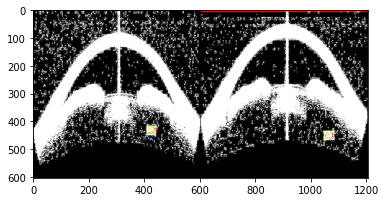

tensor([[1.7794e+01, 2.0712e-01, 3.1511e+04, 2.9578e+01, 2.3129e+01, 4.0992e+01,
         2.4170e+01, 3.4700e+02, 2.1000e+02, 5.0600e+02, 2.1200e+02, 5.5800e+02,
         1.5900e+02, 1.4600e+02, 1.0000e+00],
        [2.2957e+01, 3.8752e-01, 3.3761e+04, 2.2730e+01, 1.3969e+01, 4.2026e+01,
         2.1705e+01, 3.4600e+02, 1.8500e+02, 5.0400e+02, 2.0300e+02, 5.6600e+02,
         1.5800e+02, 1.4700e+02, 1.0000e+00]])


In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    print(inp.shape)
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
imgs, targets = next(iter(train_loader))
#print(targets)
print(imgs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(imgs)

imshow(out, )
print(targets)

In [11]:
#fine tuning connet
def train_model(model, criterion, optimizer, num_epochs=25):
    model.train()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000
    for epoch in range(num_epochs):
        
        next_batch,train_loss,valid_loss = 0,0,0
        
        
        for batch_i, (imgs, targets) in enumerate(train_loader):
            imgs = imgs.to(device)
            targets = targets.to(device)
            print(targets,targets.size())

            outputs = model(imgs)  
            print(outputs)
            loss = criterion(outputs,targets)
            print(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            next_batch = next_batch+1
            
            #scheduler.step()             

        if  train_loss<best_loss:
            best_loss = train_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            print(str(best_loss)+"\n")

        print("epoch:",epoch,"train_loss:",train_loss)  
        
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
# Model
model_ft = models.resnet18(pretrained=True)
#for param in model_ft.parameters():
    #param.requires_grad = False
num_ftrs = model_ft.fc.in_features
print(num_ftrs)
model_ft.fc = nn.Linear(num_ftrs, 15)
model_ft = model_ft.to(device)
criterion = nn.MSELoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.8)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=45)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/richards/.cache/torch/checkpoints/resnet18-5c106cde.pth



512
NO152 RE PRE
NO152 RE POST
NO136 RE PRE
NO136 RE POST
NO145 RE PRE
NO145 RE POST
tensor([[1.7794e+01, 2.0712e-01, 3.1511e+04, 2.9578e+01, 2.3129e+01, 4.0992e+01,
         2.4170e+01, 3.4700e+02, 2.1000e+02, 5.0600e+02, 2.1200e+02, 5.5800e+02,
         1.5900e+02, 1.4600e+02, 1.0000e+00],
        [2.2957e+01, 3.8752e-01, 3.3761e+04, 2.2730e+01, 1.3969e+01, 4.2026e+01,
         2.1705e+01, 3.4600e+02, 1.8500e+02, 5.0400e+02, 2.0300e+02, 5.6600e+02,
         1.5800e+02, 1.4700e+02, 1.0000e+00]]) torch.Size([2, 15])
tensor([[ 0.4208,  0.5063, -0.6448, -0.0248, -0.2727, -0.0927, -0.5423, -0.2088,
          0.3617,  0.3625, -0.4433, -0.1075,  0.1424, -0.4784, -1.1022],
        [ 0.5320,  0.4232, -1.0396,  0.0671, -0.1509,  0.1853, -0.7626, -0.2943,
          0.4927,  0.4075, -0.2645, -0.2052,  0.2377, -0.5866, -1.1478]],
       grad_fn=<AddmmBackward>)
tensor(71150216., grad_fn=<MseLossBackward>)
NO057 RE PRE
NO057 RE POST
tensor([[1.9761e+01, 5.1287e+00, 3.2865e+04, 2.6565e+01, 2.5408e

NO081 LE POST
NO081 LE PRE
tensor([[2.0143e+01, 5.0724e-01, 3.3342e+04, 2.8393e+01, 2.7248e+01, 3.9012e+01,
         2.3886e+01, 2.9200e+02, 1.9000e+02, 4.7200e+02, 1.9100e+02, 5.5300e+02,
         1.8000e+02, 1.2600e+02, 3.0000e+00],
        [1.6740e+01, 2.2625e-01, 3.1507e+04, 2.7181e+01, 3.2135e+01, 4.1855e+01,
         2.8921e+01, 2.8000e+02, 1.9500e+02, 4.4800e+02, 1.8600e+02, 5.6400e+02,
         1.6800e+02, 1.5200e+02, 3.0000e+00]]) torch.Size([2, 15])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor(nan, grad_fn=<MseLossBackward>)
NO048 LE PRE
NO048 LE POST
tensor([[2.1714e+01, 8.0234e+00, 4.2498e+04, 9.9638e+00, 2.5641e+01, 4.3285e+01,
         2.4528e+01, 3.2600e+02, 2.1200e+02, 5.3600e+02, 2.1100e+02, 5.8700e+02,
         2.1000e+02, 1.4900e+02, 4.0000e+00],
        [1.9826e+01, 1.1685e+01, 4.4520e+04, 2.5313e+01, 2.

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor(nan, grad_fn=<MseLossBackward>)
NO056 RE PRE
NO056 RE POST
tensor([[2.8157e+01, 1.3122e+01, 4.1788e+04, 1.2938e+01, 2.9899e+01, 4.0301e+01,
         2.8317e+01, 2.8300e+02, 2.2100e+02, 4.6000e+02, 2.2600e+02, 5.9900e+02,
         1.7700e+02, 1.4600e+02, 1.0000e+00],
        [1.7290e+01, 7.1690e+00, 3.7366e+04, 8.4550e+00, 3.1928e+01, 3.8367e+01,
         3.0525e+01, 3.2500e+02, 1.8600e+02, 5.2400e+02, 1.9500e+02, 6.1200e+02,
         1.9900e+02, 1.4800e+02, 1.0000e+00]]) torch.Size([2, 15])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor(nan, grad_fn=<MseLossBackward>)
NO063 LE PRE
NO063 LE POST
tensor([[2.2934e+01, 1.25

KeyboardInterrupt: 